**<font color = black size=6>实验十二：神经网络</font>**

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
import os  

本实验使用Pytorch框架搭建神经网络，其他类似的框架还有TensorFlow。若同学对TensorFlow框架更为熟悉，可使用TensorFlow完成本次实验

**<font color = blue size=4>第一部分:PyTorch介绍</font>**

这里介绍一小部分PyTorch常用的库和函数，更多需求可参阅[PyTorch官方教程](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)以及[PyTorch官方文档](https://pytorch.org/docs/stable/index.html)。

In [56]:
print(torch.__version__) # 输出当前版本

2.0.1+cpu


**<font color = green size=3>1.Tensor</font>**

Tensor与NumPy中的ndarray很相似，但Tensor可以利用GPU来加速计算（本次实验中暂不涉及这部分内容）。

1.1. Tensor的创建

In [57]:
# 创建一个未初始化的Tensor
x = torch.empty(2, 3)
print(x)

# 从一个列表创建Tensor
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 创建一个随机Tensor
x = torch.rand([3, 4])
print(x)

# 创建一个全零Tensor
x = torch.zeros([2, 3])
print(x)

# 创建一个全一Tensor
x = torch.ones([2, 3])
print(x)

tensor([[1.3076e+22, 1.0243e-11, 1.3296e+22],
        [6.4830e-10, 3.3554e-06, 4.0370e-08]])
tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[0.9314, 0.3096, 0.9157, 0.9292],
        [0.9719, 0.0694, 0.4811, 0.9078],
        [0.4407, 0.5966, 0.3987, 0.4052]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


1.2. Tensor的运算

In [58]:
# 加减法
x = torch.tensor([[1,2,3],
                  [4,5,6]])
y = torch.tensor([[6,5,4],
                  [3,2,1]])
print(x + y)
print(x - y)

# 对应位置相乘
print(x * y)
print(x.mul(y))

# 矩阵乘法
print(x.matmul(y.T))
print(x @ y.T)

# reshape
print(x.reshape(3, 2))

# 拼接
print(torch.cat([x,y], dim=0)) # 纵向拼接
print(torch.cat([x,y], dim=1)) # 横向拼接

tensor([[7, 7, 7],
        [7, 7, 7]])
tensor([[-5, -3, -1],
        [ 1,  3,  5]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[28, 10],
        [73, 28]])
tensor([[28, 10],
        [73, 28]])
tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([[1, 2, 3],
        [4, 5, 6],
        [6, 5, 4],
        [3, 2, 1]])
tensor([[1, 2, 3, 6, 5, 4],
        [4, 5, 6, 3, 2, 1]])


1.3. Tensor与ndarray的相互转换

In [59]:
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 从Tensor转换到ndarray
y = x.numpy()
print(y)

# Tensor与ndarray是共享空间的
x[:]=0
print(y)

# 从ndarray到Tensor
z = torch.from_numpy(y)
print(z)

tensor([[1, 2, 3],
        [4, 5, 6]])
[[1 2 3]
 [4 5 6]]
[[0 0 0]
 [0 0 0]]
tensor([[0, 0, 0],
        [0, 0, 0]])


**<font color = green size=3>2.梯度计算</font>**

2.1 梯度计算

In [60]:
#定义变量
a = torch.tensor([[1., 2.]], requires_grad=True)
b = torch.tensor([[3.], [4.]])
c = torch.tensor(5., requires_grad=True)

#计算输出
z = a @ b + c

#自动计算梯度
z.backward()

#输出叶子节点的梯度
print(a.grad) #z对a的梯度
print(b.grad) #由于b默认requires_grad为false，因此无法计算梯度，输出为None
print(c.grad) #z对c的梯度

tensor([[3., 4.]])
None
tensor(1.)


2.2 梯度清零

In [61]:
#支持多种运算求梯度，如torch.mean(),torch.sum()等
a = torch.ones(20, requires_grad=True)
z = torch.sum(torch.sigmoid(a))
z.backward()
print("梯度(a.grad):", a.grad)


#多次求梯度时梯度会累加，可使用tensor.grad.zero_()进行手动清零
x = torch.tensor(2., requires_grad=True)
y = x ** 2
y.backward()
print("求梯度后的结果(x.grad):", x.grad)

z = x + 3
x.grad.zero_()  #可以将这句进行手动清零的代码注释掉后查看输出结果，来看到梯度清零的作用
z.backward()
print("求梯度后的结果(x.grad):", x.grad)


梯度(a.grad): tensor([0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966])
求梯度后的结果(x.grad): tensor(4.)
求梯度后的结果(x.grad): tensor(1.)


**<font color = green size=3>3. 神经网络</font>**

3.1 神经网络的构建

In [62]:
# 定义神经网络模型，继承自nn.Module
class Net(nn.Module):
    #输入层的维度为 input_dim
    #隐藏层的维度为 hidden_dim
    #输出层的维度为 output_dim
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        # 第一个全连接层，输入维度为 input_dim，输出维度为 hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # 第二个全连接层，输入维度为 hidden_dim，输出维度为 output_dim
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # 激活函数 relu，用于在全连接层之间加入非线性变换
        self.relu = nn.ReLU()

    def forward(self, x):
        # 第一层前向传播，得到输出 out
        out = self.fc1(x)
        # 对第一层的输出应用激活函数 relu，得到 out1
        out1 = self.relu(out)
        # 第二层前向传播，得到最终输出 out2
        out2 = self.fc2(out1)
        return out1, out2


# 创建神经网络模型实例并输出
net = Net(10,5,1)
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)


3.2 神经网络参数查询

In [63]:
# 该神经网络中可学习的参数可以通过net.parameters()访问
params = list(net.parameters())
print([params[i].size() for i in range(len(params))])  
print("Parameters:",params)

[torch.Size([5, 10]), torch.Size([5]), torch.Size([1, 5]), torch.Size([1])]
Parameters: [Parameter containing:
tensor([[-0.2072,  0.0514,  0.2664,  0.1006, -0.2845,  0.1259,  0.2615, -0.2449,
          0.1303, -0.2395],
        [ 0.1953,  0.2213, -0.0226,  0.2384, -0.1639, -0.1377, -0.0541,  0.2710,
          0.0584, -0.2329],
        [-0.0844,  0.1824,  0.1033, -0.1560,  0.1725, -0.0645,  0.1510,  0.2715,
         -0.1865, -0.1923],
        [-0.0417, -0.1825, -0.0053, -0.2236, -0.2774, -0.1391, -0.1335, -0.1185,
          0.2040, -0.1034],
        [-0.2912,  0.1067, -0.2208, -0.0126,  0.1313,  0.2133,  0.1051, -0.2652,
         -0.2685, -0.3002]], requires_grad=True), Parameter containing:
tensor([ 0.1748,  0.1523,  0.1159, -0.1668, -0.1025], requires_grad=True), Parameter containing:
tensor([[ 0.2415,  0.2701, -0.1672, -0.3798,  0.2291]], requires_grad=True), Parameter containing:
tensor([-0.1796], requires_grad=True)]


3.3 神经网络前向传播

In [64]:
net.eval()
#输入维度为10，生成数据
input=torch.ones([1,10])
input=input.float()

# 进行一次forward()前向传播
output1, output2  = net(input) 

# 前向传播并输出每一层的输出值
print("Output of first layer:", output1)
print("Output of second layer:", output2)

Output of first layer: tensor([[0.1350, 0.5253, 0.3128, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
Output of second layer: tensor([[-0.0575]], grad_fn=<AddmmBackward0>)


3.4 神经网络反向传播

In [65]:
loss_fn = nn.MSELoss()
target = torch.randn(1, 1)
loss = loss_fn(output2, target)

# 反向传播并输出每一层的梯度
net.zero_grad()
loss.backward()

print("Gradients of first layer:")
print(net.fc1.weight.grad)
print(net.fc1.bias.grad)

print("Gradients of second layer:")
print(net.fc2.weight.grad)
print(net.fc2.bias.grad)

Gradients of first layer:
tensor([[-0.5163, -0.5163, -0.5163, -0.5163, -0.5163, -0.5163, -0.5163, -0.5163,
         -0.5163, -0.5163],
        [-0.5773, -0.5773, -0.5773, -0.5773, -0.5773, -0.5773, -0.5773, -0.5773,
         -0.5773, -0.5773],
        [ 0.3574,  0.3574,  0.3574,  0.3574,  0.3574,  0.3574,  0.3574,  0.3574,
          0.3574,  0.3574],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]])
tensor([-0.5163, -0.5773,  0.3574,  0.0000,  0.0000])
Gradients of second layer:
tensor([[-0.2885, -1.1228, -0.6686,  0.0000,  0.0000]])
tensor([-2.1376])


3.5 训练神经网络的全过程例子

In [66]:
# 创建一个简单的线性回归模型
model = nn.Linear(1, 1)
print(list(model.parameters()))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch=10

#生成数据
inputs = torch.tensor([[1.0], [2.0], [3.0]])
labels = torch.tensor([[2.0], [4.0], [6.0]])

# 模拟训练过程
for epoch in range(Epoch):
    # 模拟输入数据和标签
    
    # 前向传播
    outputs = model(inputs)

    # 计算损失
    loss = criterion(outputs, labels)
    
    #梯度清零
    optimizer.zero_grad()
      
    # 反向传播
    loss.backward()

    # 更新参数
    optimizer.step()

    # 打印梯度值
    print('Epoch [{}/{}], Loss: {}'.format(epoch+1,Epoch, loss),'. Gradient: {}'.format(model.weight.grad))
    #print('Gradient: {}'.format(model.weight.grad))


[Parameter containing:
tensor([[0.4179]], requires_grad=True), Parameter containing:
tensor([0.9746], requires_grad=True)]
Epoch [1/10], Loss: 6.463512420654297 . Gradient: tensor([[-10.8683]])
Epoch [2/10], Loss: 5.1666083335876465 . Gradient: tensor([[-9.6787]])
Epoch [3/10], Loss: 4.141198635101318 . Gradient: tensor([[-8.6211]])
Epoch [4/10], Loss: 3.3303921222686768 . Gradient: tensor([[-7.6807]])
Epoch [5/10], Loss: 2.6892194747924805 . Gradient: tensor([[-6.8447]])
Epoch [6/10], Loss: 2.1821346282958984 . Gradient: tensor([[-6.1013]])
Epoch [7/10], Loss: 1.7810395956039429 . Gradient: tensor([[-5.4404]])
Epoch [8/10], Loss: 1.4637255668640137 . Gradient: tensor([[-4.8527]])
Epoch [9/10], Loss: 1.2126383781433105 . Gradient: tensor([[-4.3302]])
Epoch [10/10], Loss: 1.013899326324463 . Gradient: tensor([[-3.8656]])


3.5 神经网络参数更新

1) 用梯度下降法(手动)更新net中的参数

In [67]:
#for f in net.parameters():
    #f.data.sub_(f.grad.data * learning_rate)

2) 用PyTorch的优化器来更新net中的参数

In [68]:
#选择优化器
#optimizer = optim.SGD(net.parameters(), lr=0.01)

# 建立循环:
#optimizer.zero_grad()             # 梯度清零
#output = net(input)               # 前向传播
#loss = criterion(output, target)  # 计算误差
#loss.backward()                   # 后向传播
#optimizer.step()                  # 参数更新

**<font color = blue size=4>第二部分:实验内容</font>**

[Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)是一个关于红酒品质的数据集，总共有1599个样本，每个样本包含11个(都是连续的)特征以及1个标签，每个标签的取值是连续的。本次实验已经按照8：2的比例划分成了训练数据集'wine_train.csv'以及测试数据集'wine_test.csv'，且每个数据集都已经做了归一化处理。

<span style="color:purple">1) 读入训练数据集'wine_train.csv'与测试数据集'wine_test.csv'。</span>

In [69]:

# 导入数据集
train_data = pd.read_csv("wine_train.csv").values
test_data =  pd.read_csv("wine_test.csv").values

# 分离训练集特征与标签
X_train = train_data[:,:-1]
y_train = train_data[:,-1]

# 分离测试集特征与标签
X_test  = test_data[:,:-1]
y_test  = test_data[:,-1]


<span style="color:purple">2) 利用线性层和激活函数搭建一个神经网络，要求输入和输出维度与数据集维度一致，而神经网络深度、隐藏层大小、激活函数种类等超参数自行调整。</span>

In [70]:
import torch.nn as nn

class Net(nn.Module):

    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Net, self).__init__()
        # 第一个全连接层，输入维度为 input_dim，输出维度为 hidden_dim1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # 第二个全连接层，输入维度为 hidden_dim1，输出维度为 hidden_dim2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # 第三个全连接层，输入维度为 hidden_dim2，输出维度为 output_dim
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        # 激活函数 sigmoid，用于在全连接层之间加入非线性变换
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 第一层全连接层的计算，将输入 x 映射到隐藏层1
        out = self.fc1(x)
        # 应用激活函数 sigmoid，引入非线性变换
        out = self.sigmoid(out)
        # 第二层全连接层的计算，将隐藏层1的输出映射到隐藏层2
        out = self.fc2(out)
        # 应用激活函数 sigmoid，引入非线性变换
        out = self.sigmoid(out)
        # 第三层全连接层的计算，将隐藏层2的输出映射到最终输出
        out = self.fc3(out)
        # 返回神经网络的输出
        return out

# 数据集维度
input_dim = X_train.shape[1]
output_dim = 1

# 超参数
hidden_dim1 = 64
hidden_dim2 = 32
learning_rate = 0.001

# 构造模型
model = Net(input_dim, hidden_dim1, hidden_dim2, output_dim)


<span style="color:purple">3) 用PyTorch的优化器(随机梯度下降)来进行模型参数更新，记下每轮迭代中的训练损失和测试损失。</span>

In [71]:
# 定义损失函数和优化器
criterion = nn.MSELoss()    # 均方误差损失函数，适用于回归问题
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 将数据转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)

# 定义空列表来存储训练和测试损失
train_losses = []
test_losses = []

Epoch = 60
for epoch in range(Epoch):
    
    # 前向传播
    outputs = model(X_train_tensor)

    # 计算训练损失
    loss = criterion(outputs, y_train_tensor)
    
    # 梯度清零
    optimizer.zero_grad()
      
    # 反向传播
    loss.backward()

    # 更新参数
    optimizer.step()

    # 记录训练损失
    train_losses.append(loss.item())

    # 在测试集上计算损失
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    # 打印训练损失
    print(f'Epoch [{epoch+1:02d}/{Epoch:02d}], Train Loss: {loss.item():.9f}, Test Loss: {test_loss.item():.9f}')


Epoch [01/60], Train Loss: 0.025939258, Test Loss: 0.026919529
Epoch [02/60], Train Loss: 0.025846926, Test Loss: 0.026918482
Epoch [03/60], Train Loss: 0.025873376, Test Loss: 0.026920762
Epoch [04/60], Train Loss: 0.025882790, Test Loss: 0.026899174
Epoch [05/60], Train Loss: 0.025855457, Test Loss: 0.026882380
Epoch [06/60], Train Loss: 0.025827128, Test Loss: 0.026885519
Epoch [07/60], Train Loss: 0.025817990, Test Loss: 0.026899252
Epoch [08/60], Train Loss: 0.025822980, Test Loss: 0.026903223
Epoch [09/60], Train Loss: 0.025824314, Test Loss: 0.026888955
Epoch [10/60], Train Loss: 0.025813522, Test Loss: 0.026863387
Epoch [11/60], Train Loss: 0.025795996, Test Loss: 0.026838150
Epoch [12/60], Train Loss: 0.025781268, Test Loss: 0.026820386
Epoch [13/60], Train Loss: 0.025774177, Test Loss: 0.026809473
Epoch [14/60], Train Loss: 0.025771927, Test Loss: 0.026800314
Epoch [15/60], Train Loss: 0.025767924, Test Loss: 0.026789600
Epoch [16/60], Train Loss: 0.025758473, Test Loss: 0.02

<span style="color:purple">4) 画出训练损失和测试损失关于迭代轮数的折线图。</span>

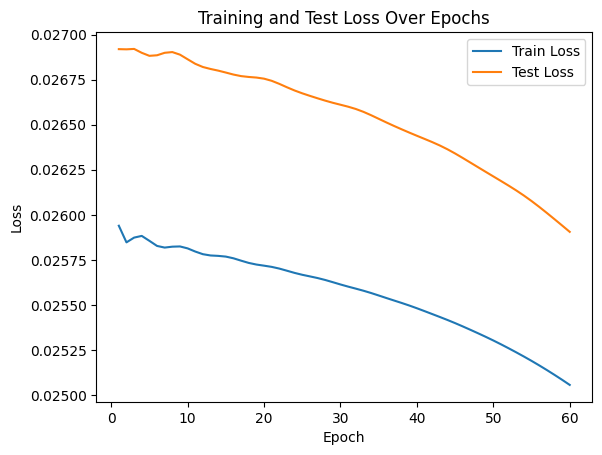

In [72]:

# 绘制训练损失和测试损失的折线图
plt.plot(range(1, Epoch+1), train_losses, label='Train Loss')
plt.plot(range(1, Epoch+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()


**<font color = blue size=4>第三部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可

二、本次实验分为两周完成，实验报告提交截止日期: 12月15号14:20  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  

实验十二(神经网络)的实验报告上交地址: https://send2me.cn/Wk9FsyYO/SKCBsWeFtvwQsg

三、课堂课件获取地址:https://www.jianguoyun.com/p/DWHYtsEQp5WhChjwtKoFIAA
实验内容获取地址:https://www.jianguoyun.com/p/DbNY_SIQp5WhChjvtKoFIAA